## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-07-16 20:23:33.714297: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 20:23:35.200926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 20:23:36.678127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib 

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 9.3%
RAM Usage: 3.3%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [9]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

In [10]:
# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(dataset='UKBB', parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid,
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping, 
    dataset='UKBB', 
    parcellation='S456'
)

batch_size = 512

# Create global dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

# Create datasets for each subnetwork
unique_networks = np.unique(network_labels)
network_datasets = {}
print("Creating datasets for each subnetwork...")

for network in unique_networks:
    # Create mask for current network
    network_mask = network_labels == network
    
    # Subset data for this network
    X_network = X_valid[network_mask]
    Y_network = Y_valid[network_mask][:, network_mask]
    coords_network = coords_valid[network_mask]
    
    # Create mapping from network indices to true indices
    network_indices = np.where(network_mask)[0]
    network2true_mapping = {i: valid2true_mapping[idx] for i, idx in enumerate(network_indices)}
    
    # Create dataset for this network
    network_datasets[network] = RegionPairDataset(
        X=X_network,
        Y=Y_network, 
        coords=coords_network,
        valid2true_mapping=network2true_mapping, 
        dataset='UKBB', 
        parcellation='S456'
    )
    print(f"Network {network}: {len(network_datasets[network])} region pairs")

# Create dataloaders for each network
batch_size = 512
network_dataloaders = {
    network: DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    ) for network, dataset in network_datasets.items()
}


Loading data...
Creating RegionPairDataset...
Creating datasets for each subnetwork...
Network Cerebellum: 72 region pairs
Network Cont: 2652 region pairs
Network Default: 8190 region pairs
Network DorsAttn: 2070 region pairs
Network Limbic: 650 region pairs
Network SalVentAttn: 2162 region pairs
Network SomMot: 5852 region pairs
Network Subcortical: 2070 region pairs
Network Vis: 3660 region pairs


Load in model trained on best random train-test split

In [11]:
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# Set up base model with the same hyperparameters used for training
smt_base_model = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=20,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.4,
    transformer_dropout=0.4,
    aug_prob=0.0,
    deep_hidden_dims=[512, 256, 128],
    binarize=False
)

# Load saved weights
smt_base_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base_seed9fold3.pt"))
smt_base_model.eval()
smt_base_model.to("cuda")

  warnings.warn(



Number of learnable parameters in SMT model: 4676235


SharedSelfAttentionModel(
  (encoder): OptimizedModule(
    (_orig_mod): FastSelfAttentionEncoder(
      (input_projection): Linear(in_features=20, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.4, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.4, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (0): Linear(in_features=7380, out_features=512, bias=True)
    (1): ReLU()
 

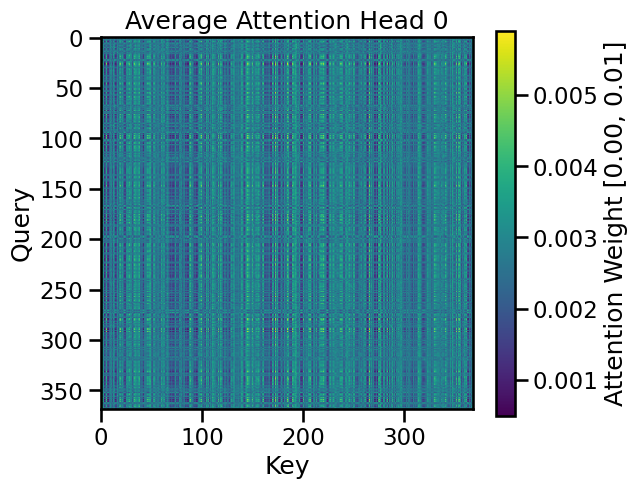

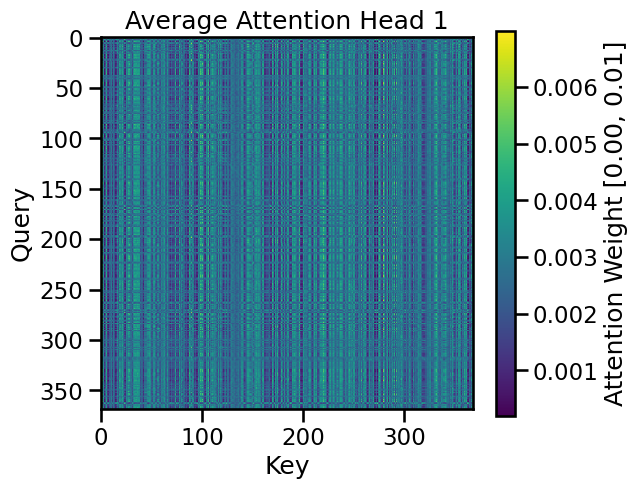

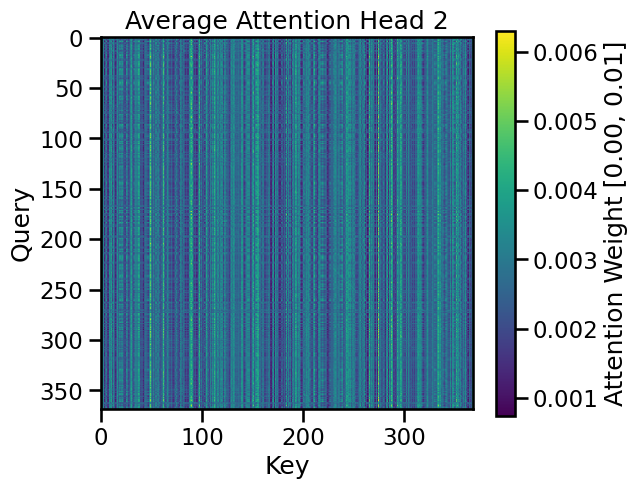

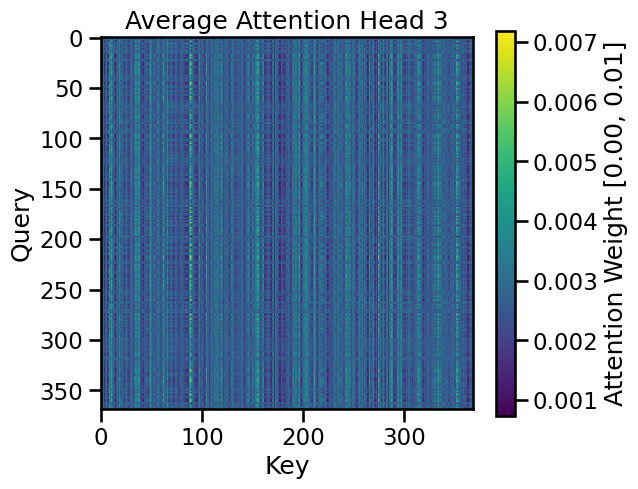

In [ ]:
# UKBB
# predictions_ukbb_base, targets_ukbb_base = smt_base_model.predict(dataloader, 
#                                                                 collect_attn=True, 
#                                                                 save_attn_path='attn_base_SMT_UKBB_seed9fold3.npy')

Evaluate attention heads

In [81]:
# Preliminaries

# Get valid genes from load_transcriptome
from data.data_load import load_transcriptome

X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')

valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')
print('len(valid_refgenome): ', len(valid_refgenome))

# Create gene groups/tokens
token_chunk_size = 20
num_tokens = len(valid_refgenome) // token_chunk_size
print('len(valid_genes): ', len(valid_genes))
print('num_tokens: ', num_tokens)

gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)

# Get chromosome switch points
chrom_switches = []
for i in range(1, len(gene_tokens)):
    if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
        chrom_switches.append(i)

gene_tokens


valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

[{'token_id': 0,
  'genes': ['LOC729737',
   'LINC01128',
   'SAMD11',
   'PERM1',
   'HES4',
   'ISG15',
   'AGRN',
   'TNFRSF4',
   'B3GALT6',
   'ACAP3',
   'PUSL1',
   'DVL1',
   'MXRA8',
   'CCNL2',
   'ANKRD65',
   'FNDC10',
   'CDK11A',
   'GABRD',
   'RER1',
   'PEX10'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 1,
  'genes': ['PLCH2',
   'HES5',
   'TNFRSF14',
   'ARHGEF16',
   'TPRG1L',
   'AJAP1',
   'CHD5',
   'TNFRSF25',
   'PLEKHG5',
   'NOL9',
   'PHF13',
   'CAMTA1',
   'PER3',
   'ERRFI1',
   'SLC45A1',
   'ENO1',
   'SLC2A5',
   'SPSB1',
   'TMEM201',
   'PIK3CD'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 2,
  'genes': ['CLSTN1',
   'CTNNBIP1',
   'UBE4B',
   'PGD',
   'TARDBP',
   'MASP2',
   'SRM',
   'FBXO2',
   'FBXO44',
   'DRAXIN',
   'CLCN6',
   'NPPA',
   'NPPB',
   'VPS13D',
   'DHRS3',
   'LRRC38',
   'PDPN',
   'PRDM2',
   'KAZN',
   'EFHD2'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 3,
  'genes': ['AGMAT',
   'PLEKHM2',
   'SLC25A34',
   '

In [82]:
# Get unique chromosomes
unique_chroms = []
for token in gene_tokens:
    if token['chromosome'] not in unique_chroms:
        unique_chroms.append(token['chromosome'])

print(f"Number of unique chromosomes: {len(unique_chroms)}")
print("\nUnique chromosomes:")
for chrom in unique_chroms:
    print(chrom)

# Count number of chromosome switches
num_switches = len(chrom_switches)
print(f"\nNumber of chromosome switch points: {num_switches}")

print("\nChromosome switch points (token indices):")
for i, switch_point in enumerate(chrom_switches):
    prev_chrom = gene_tokens[switch_point-1]['chromosome']
    curr_chrom = gene_tokens[switch_point]['chromosome']
    print(f"Switch {i+1}: Token {switch_point} - {prev_chrom} → {curr_chrom}")



Number of unique chromosomes: 23

Unique chromosomes:
NC_000001.11
NC_000002.12
NC_000003.12
NC_000004.12
NC_000005.10
NC_000006.12
NC_000007.14
NC_000008.11
NC_000009.12
NC_000010.11
NC_000011.10
NC_000012.12
NC_000013.11
NC_000014.9
NC_000015.10
NC_000016.10
NC_000017.11
NC_000018.10
NC_000019.10
NC_000020.11
NC_000021.9
NC_000022.11
NC_000023.11

Number of chromosome switch points: 22

Chromosome switch points (token indices):
Switch 1: Token 37 - NC_000001.11 → NC_000002.12
Switch 2: Token 62 - NC_000002.12 → NC_000003.12
Switch 3: Token 84 - NC_000003.12 → NC_000004.12
Switch 4: Token 99 - NC_000004.12 → NC_000005.10
Switch 5: Token 118 - NC_000005.10 → NC_000006.12
Switch 6: Token 137 - NC_000006.12 → NC_000007.14
Switch 7: Token 154 - NC_000007.14 → NC_000008.11
Switch 8: Token 168 - NC_000008.11 → NC_000009.12
Switch 9: Token 182 - NC_000009.12 → NC_000010.11
Switch 10: Token 198 - NC_000010.11 → NC_000011.10
Switch 11: Token 219 - NC_000011.10 → NC_000012.12
Switch 12: Token 2

Plot attention head exploration

In [83]:
# Global font size parameter
FONTSIZE = 24

def plot_all_attention_heads(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    chrom_switches = chrom_switches[:-1]
    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        if head == 0:  # Only add labels for first plot
            axes[head].set_xlabel("Key", fontsize=FONTSIZE)
            axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add chromosome switch points as ticks
        axes[head].set_xticks(chrom_switches)
        axes[head].set_yticks(chrom_switches)
        axes[head].tick_params(axis='both', which='major', labelsize=FONTSIZE-10)
        axes[head].tick_params(axis='x', rotation=90)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xticks(chrom_switches)
    axes[-1].set_yticks(chrom_switches)
    axes[-1].tick_params(axis='both', which='major', labelsize=FONTSIZE-8)
    axes[-1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

    # Plot colorbar separately
    # fig_cbar = plt.figure(figsize=(2, 6))
    # cbar = plt.colorbar(im, cax=plt.gca(), label=f"[{vmin:.2f}, {vmax:.2f}]")
    # cbar.ax.tick_params(labelsize=FONTSIZE-4)
    # cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    # plt.show()

def plot_average_head(avg_attn, chrom_switches, vectorize=False):
    '''
    Plot average attention weights across all heads
    If vectorize=True, return columnwise mean of average attention
    '''
    
    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    chrom_switches = chrom_switches[:-1]

    plt.figure(figsize=(8, 7))
    vmin, vmax = avg_head.min(), avg_head.max()
    im = plt.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    plt.title("Average Attention Across All Heads", fontsize=FONTSIZE+2)
    plt.xlabel("Key", fontsize=FONTSIZE)
    plt.ylabel("Query", fontsize=FONTSIZE)
    plt.xticks(chrom_switches, fontsize=FONTSIZE-6, rotation=90)
    plt.yticks(chrom_switches, fontsize=FONTSIZE-6)
    plt.show()

    if vectorize:
        return avg_head.sum(axis=0)
    return avg_head


def plot_all_attention_heads_true_ticks(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    max_idx = attn_weights.shape[1]
    tick_indices = list(range(0, max_idx, 5))
    chrom_switches = chrom_switches[:-1]

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        axes[head].set_xlabel("Key", fontsize=FONTSIZE)
        axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add indices as ticks with smaller font
        axes[head].set_xticks(tick_indices)
        axes[head].set_yticks(tick_indices)
        axes[head].tick_params(axis='both', which='major', labelsize=6)
        cbar = fig.colorbar(im, ax=axes[head], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
        cbar.ax.tick_params(labelsize=FONTSIZE-8)
        cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xlabel("Key", fontsize=FONTSIZE)
    axes[-1].set_ylabel("Query", fontsize=FONTSIZE)
    axes[-1].set_xticks(tick_indices)
    axes[-1].set_yticks(tick_indices)
    axes[-1].tick_params(axis='both', which='major', labelsize=6)
    cbar = fig.colorbar(im, ax=axes[-1], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    plt.tight_layout()
    plt.show()


UKBB Model Attention:


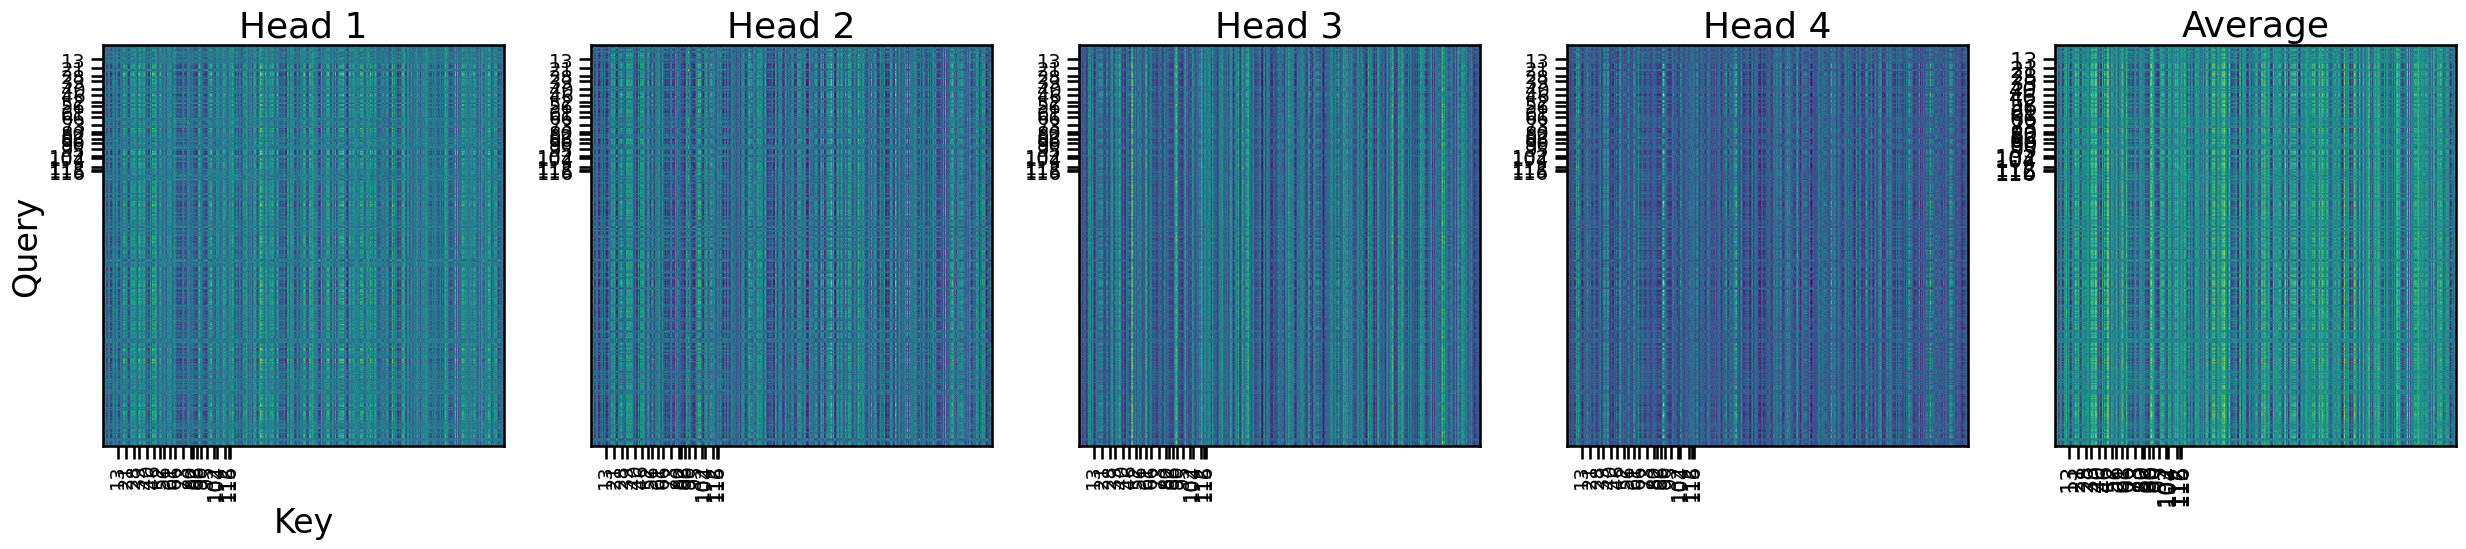

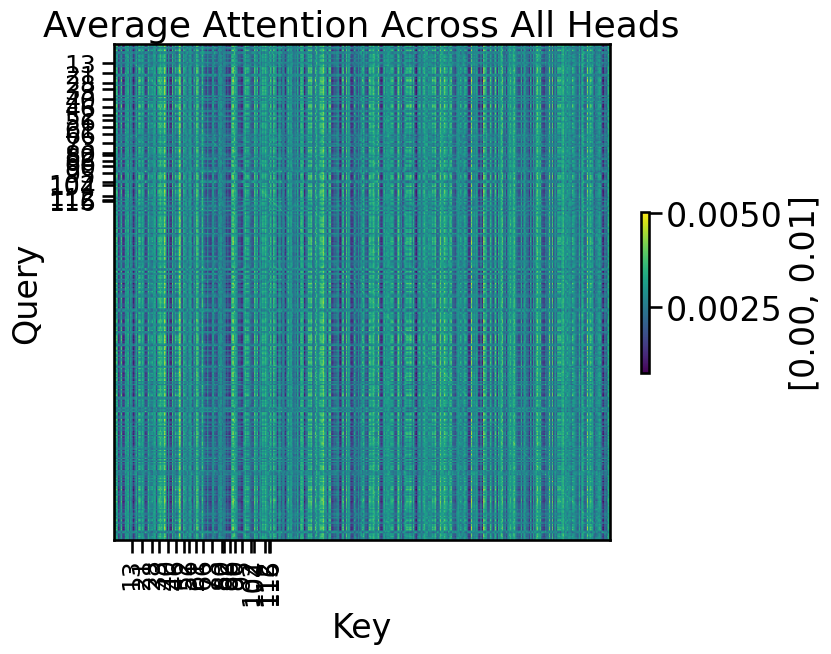

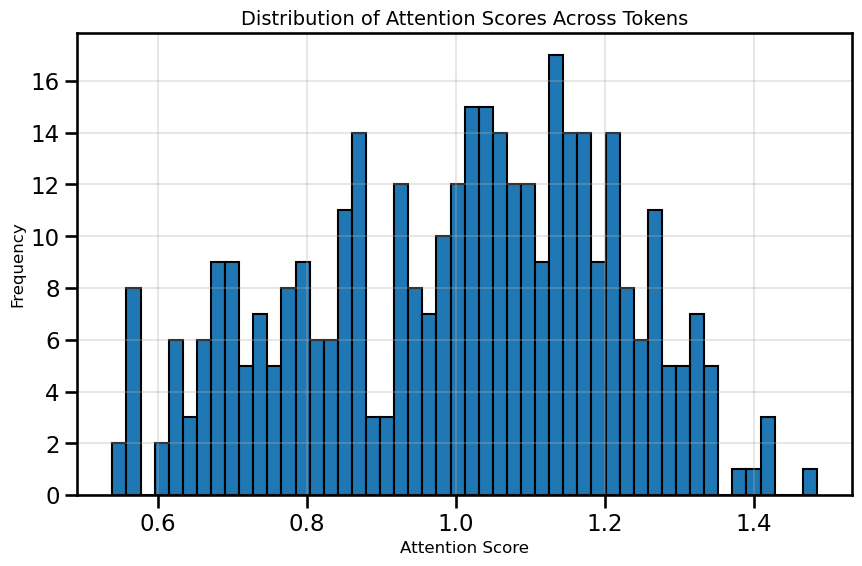

In [121]:
# Load if already computed
avg_base_smt_20dim_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_UKBB_seed9fold3.npy')

# Plot attention weights for UKBB model
print("UKBB Model Attention:")
plot_all_attention_heads(avg_base_smt_attn_ukbb, chrom_switches)

summed_attention_vec = plot_average_head(avg_base_smt_attn_ukbb, chrom_switches, vectorize=True)

plt.figure(figsize=(10,6))
plt.hist(summed_attention_vec, bins=50, edgecolor='black')
plt.xlabel('Attention Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Attention Scores Across Tokens', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


In [122]:
def create_gene_attention_df(gene_tokens, summed_attention_vec):
    """
    Create a dataframe mapping genes to their attention scores.
    
    Args:
        gene_tokens (list): List of dictionaries containing gene information per token
        summed_attention_vec (np.array): Vector of attention scores for each token
        
    Returns:
        pd.DataFrame: DataFrame with columns 'Gene' and 'Attention_Score'
    """
    # Add attention scores to gene tokens
    for i, token in enumerate(gene_tokens):
        token['attention_score'] = summed_attention_vec[i]
        
    # Create lists to store gene IDs and their attention scores
    genes = []
    attention_scores = []
    
    # Iterate through tokens and extract gene-attention pairs
    for token in gene_tokens:
        # Each gene in the token gets the same attention score
        for gene in token['genes']:
            genes.append(gene)
            attention_scores.append(token['attention_score'])
            
    # Create and return dataframe
    gene_attention_df = pd.DataFrame({
        'Gene': genes,
        'Attention_Score': attention_scores
    })
    
    return gene_attention_df

# Usage
gene_attention_df = create_gene_attention_df(gene_tokens, summed_attention_vec)
print("Created gene-attention dataframe with shape:", gene_attention_df.shape)
gene_attention_df.head()


Created gene-attention dataframe with shape: (7380, 2)


Gene  Attention_Score
0  LOC729737         0.936995
1  LINC01128         0.936995
2     SAMD11         0.936995
3      PERM1         0.936995
4       HES4         0.936995

GSEA

In [125]:
gene_attention_df = gene_attention_df.sort_values('Attention_Score', ascending=False)
# write without header
gene_attention_df[['Gene','Attention_Score']].to_csv(f'gene_attention_{token_chunk_size}_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)

In [132]:
import gseapy as gp

gene_attention_df = gene_attention_df.sort_values('Attention_Score', ascending=False)
# write without header
gene_attention_df[['Gene','Attention_Score']].to_csv(f'gene_attention_{token_chunk_size}_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)

pre_res = gp.prerank(
    rnk='gene_attention.rnk',
    gene_sets='KEGG_2021_Human',
    min_size=15,              # Minimum gene set size
    max_size=20,             # Maximum gene set size
    permutation_num=1000,     # Number of permutations
    weight=1,                 # Weight for ranking
    ascending=False,          # Sort descending
    threads=4,                # Number of threads
    figsize=[6.5,6],         # Figure size
    outdir=None,             # Don't write files
    format='pdf',            # Figure format
    graph_num=20,            # Plot top 20 enriched sets
    no_plot=False,           # Generate plots
    seed=42,                 # Random seed
    verbose=True             # Print progress
)

2025-07-16 21:32:10,590 [WARNING] Duplicated values found in preranked stats: 95.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-16 21:32:10,591 [INFO] Parsing data files for GSEA.............................
2025-07-16 21:32:10,592 [INFO] Enrichr library gene sets already downloaded in: /home/asr655/.cache/gseapy, use local file
2025-07-16 21:32:10,639 [INFO] 0292 gene_sets have been filtered out when max_size=20 and min_size=15
2025-07-16 21:32:10,640 [INFO] 0028 gene_sets used for further statistical testing.....
2025-07-16 21:32:10,640 [INFO] Start to run GSEA...Might take a while..................
2025-07-16 21:32:10,996 [INFO] Congratulations. GSEApy runs successfully................



In [133]:
pre_res.res2d.head(20)

Name                                          Term        ES       NES  \
0   prerank             Ribosome biogenesis in eukaryotes  0.445868  1.968165   
1   prerank                      Type I diabetes mellitus  0.450423  1.858016   
2   prerank                        Fanconi anemia pathway -0.344805 -1.795223   
3   prerank                    Nucleotide excision repair  -0.31214 -1.568692   
4   prerank        Various types of N-glycan biosynthesis  0.342358   1.45729   
5   prerank  Intestinal immune network for IgA production  0.339781  1.411673   
6   prerank   Amino sugar and nucleotide sugar metabolism   0.29909  1.363069   
7   prerank              Mucin type O-glycan biosynthesis  0.284352  1.270814   
8   prerank                         Tryptophan metabolism -0.253829 -1.269691   
9   prerank                                Bladder cancer  0.283112  1.244522   
10  prerank      Vasopressin-regulated water reabsorption  0.270599  1.237806   
11  prerank                              Circadian rhythm  0.260653    1.1283   
12  prerank                         Pyrimidine metabolism  0.231598  1.046806   
13  prerank                        Cholesterol metabolism -0.200636 -1.036248   
14  prerank                       Sphingolipid metabolism -0.166401 -0.942136   
15  prerank               Fructose and mannose metabolism   0.19952  0.861262   
16  prerank                Glycosphingolipid biosynthesis  0.184024    0.8055   
17  prerank                  Steroid hormone biosynthesis  0.192357  0.789338   
18  prerank                Collecting duct acid secretion -0.153836 -0.729086   
19  prerank       Proximal tubule bicarbonate reclamation  0.173583   0.72688   

   NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0   0.003817  0.078994      0.082  10/18  21.33%   
1   0.005236  0.088987      0.174  12/15  40.38%   
2   0.018779  0.094356   0.076229  15/17  48.96%   
3    0.03913  0.153917   0.223671  15/16  59.32%   
4   0.084975  0.587854      0.835  10/18  29.01%   
5    0.09715  0.544867      0.892  10/16  35.72%   
6   0.132099  0.542107      0.936   8/20  19.89%   
7   0.199243  0.662882      0.988   9/19  30.43%   
8   0.173228  0.381354   0.616851  13/15  57.03%   
9   0.200734  0.628688      0.993  10/19  33.01%   
10  0.209618  0.563307      0.994  13/20  45.72%   
11  0.325062  0.729134        1.0   9/17  35.03%   
12  0.412562  0.839143        1.0  12/20  46.31%   
13  0.404762  0.671988   0.912738  11/16  40.18%   
14   0.52551  0.721348    0.95988  18/20  69.89%   
15  0.646907       1.0        1.0   8/17  34.99%   
16  0.678756       1.0        1.0  11/18  53.01%   
17  0.745695       1.0        1.0  10/15  55.01%   
18  0.801762  0.973238   0.994985  15/15  84.66%   
19  0.806452       1.0        1.0   4/16  15.73%   

                                           Lead_genes  
0   RPP25;RAN;IMP4;POP7;HEATR1;NHP2;TCOF1;BMS1;EMG...  
1   IL1B;ICA1;HLA-DMB;HLA-DMA;HLA-DPB1;HLA-DPA1;HL...  
2   FANCL;ERCC4;RMI2;RPA2;PMS2;TOP3A;HES1;REV1;RAD...  
3   ERCC4;RPA2;RFC1;ERCC2;ERCC8;POLE4;ERCC6;RFC3;R...  
4   HEXB;TUSC3;MGAT1;MGAT4B;ST3GAL3;B4GALT2;ALG2;M...  
5   MAP3K14;TNFSF13B;MADCAM1;HLA-DMB;HLA-DMA;HLA-D...  
6         MPI;HEXB;GNPDA2;GFPT2;CYB5R3;NAGK;GALT;CMAS  
7   GCNT4;GALNT9;GCNT1;GALNT11;GALNT18;GALNT13;GAL...  
8   KYNU;DDC;ALDH7A1;HADH;ECHS1;DLD;ACAT2;MAOB;MAO...  
9   MAPK1;DAPK3;MAP2K2;KRAS;ERBB2;CDKN2A;E2F3;MAPK...  
10  CREB3L3;NSF;DCTN4;ADCY3;CREB3L2;DYNC1I1;DYNLL1...  
11  BHLHE40;CLOCK;PER1;ARNTL;PER3;NR1D1;PRKAG2;SKP...  
12  ENTPD4;TK2;NUDT2;UPP2;DPYD;PNP;DCTPP1;TYMP;ENT...  
13  APOC1;APOE;OSBPL5;NPC2;ABCA1;SORT1;LRPAP1;VAPA...  
14  KDSR;B4GALT6;CERS1;SMPD3;PSAP;UGCG;PLPP1;UGT8;...  
15            MPI;KHK;PFKFB2;TPI1;PFKL;ALDOA;TKFC;HK1  
16  HEXB;ST3GAL3;B4GALT2;ST8SIA1;ST3GAL5;B3GNT4;B3...  
17  SRD5A3;HSD11B1L;HSD11B1;SRD5A1;STS;HSD17B12;CY...  
18  ATP6V1G2;TCIRG1;ATP6V1E2;CA2;ATP6V1E1;ATP6V1C1...  
19                           SLC4A4;AQP1;ATP1B2;GLUD1

  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))



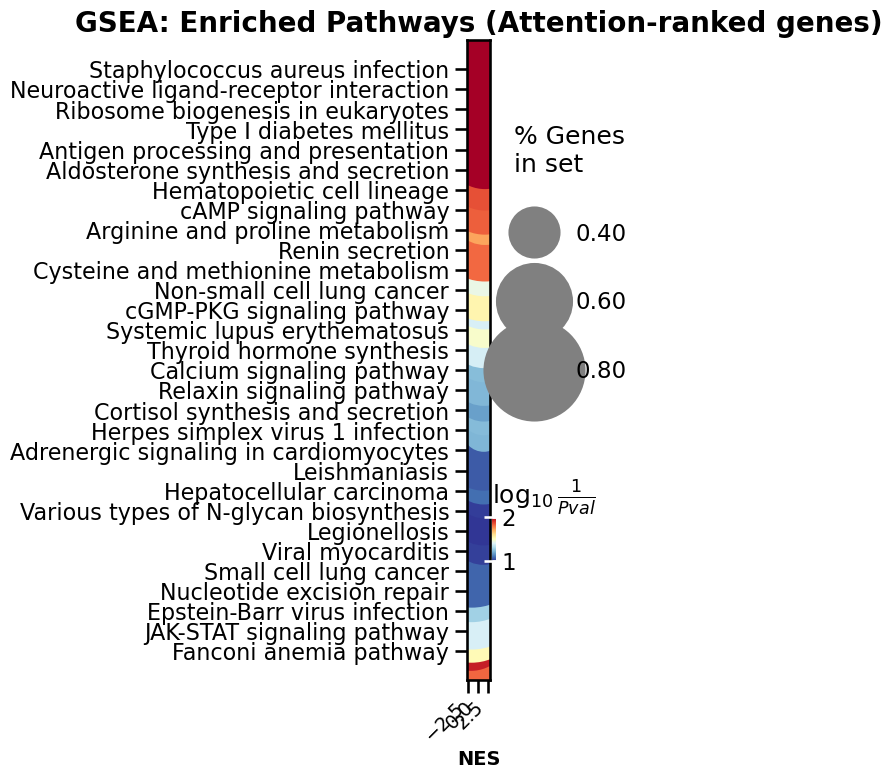

In [ ]:
from gseapy.plot import dotplot

ax = dotplot(
    df=pre_res.res2d,
    title='GSEA: Enriched Pathways (Attention‑ranked genes)',
    column='NOM p-val',  # Default column name for FDR values
    x='NES',                   # x-axis = normalized enrichment score 
    y='Term',                  # y-axis = pathway names
    cutoff=0.1,              # Only show terms with adj p-value < 0.05
    top_term=15,              # Show top 15 enriched terms
    size=10,                  # Base dot size
    figsize=(6,8),
    cmap='RdYlBu_r',         # Red-Yellow-Blue colormap (reversed)
    xticklabels_rot=45,      # Rotate x-axis labels 45 degrees
    marker='o'               # Use circular markers
)
ax.figure.tight_layout()
# ax.figure.savefig('gsea_dotplot.pdf', dpi=300)

Token dim 60 

In [105]:
# Preliminaries

# Get valid genes from load_transcriptome
from data.data_load import load_transcriptome

X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')

valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')
print('len(valid_refgenome): ', len(valid_refgenome))

# Create gene groups/tokens
token_chunk_size = 60
num_tokens = len(valid_refgenome) // token_chunk_size
print('len(valid_genes): ', len(valid_genes))
print('num_tokens: ', num_tokens)

gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)

# Get chromosome switch points
chrom_switches = []
for i in range(1, len(gene_tokens)):
    if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
        chrom_switches.append(i)

gene_tokens


valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

[{'token_id': 0,
  'genes': ['LOC729737',
   'LINC01128',
   'SAMD11',
   'PERM1',
   'HES4',
   'ISG15',
   'AGRN',
   'TNFRSF4',
   'B3GALT6',
   'ACAP3',
   'PUSL1',
   'DVL1',
   'MXRA8',
   'CCNL2',
   'ANKRD65',
   'FNDC10',
   'CDK11A',
   'GABRD',
   'RER1',
   'PEX10',
   'PLCH2',
   'HES5',
   'TNFRSF14',
   'ARHGEF16',
   'TPRG1L',
   'AJAP1',
   'CHD5',
   'TNFRSF25',
   'PLEKHG5',
   'NOL9',
   'PHF13',
   'CAMTA1',
   'PER3',
   'ERRFI1',
   'SLC45A1',
   'ENO1',
   'SLC2A5',
   'SPSB1',
   'TMEM201',
   'PIK3CD',
   'CLSTN1',
   'CTNNBIP1',
   'UBE4B',
   'PGD',
   'TARDBP',
   'MASP2',
   'SRM',
   'FBXO2',
   'FBXO44',
   'DRAXIN',
   'CLCN6',
   'NPPA',
   'NPPB',
   'VPS13D',
   'DHRS3',
   'LRRC38',
   'PDPN',
   'PRDM2',
   'KAZN',
   'EFHD2'],
  'chromosome': 'NC_000001.11'},
 {'token_id': 1,
  'genes': ['AGMAT',
   'PLEKHM2',
   'SLC25A34',
   'UQCRHL',
   'SRARP',
   'SZRD1',
   'CROCCP2',
   'SDHB',
   'RCC2',
   'ARHGEF10L',
   'IGSF21',
   'ALDH4A1',
   'IFFO

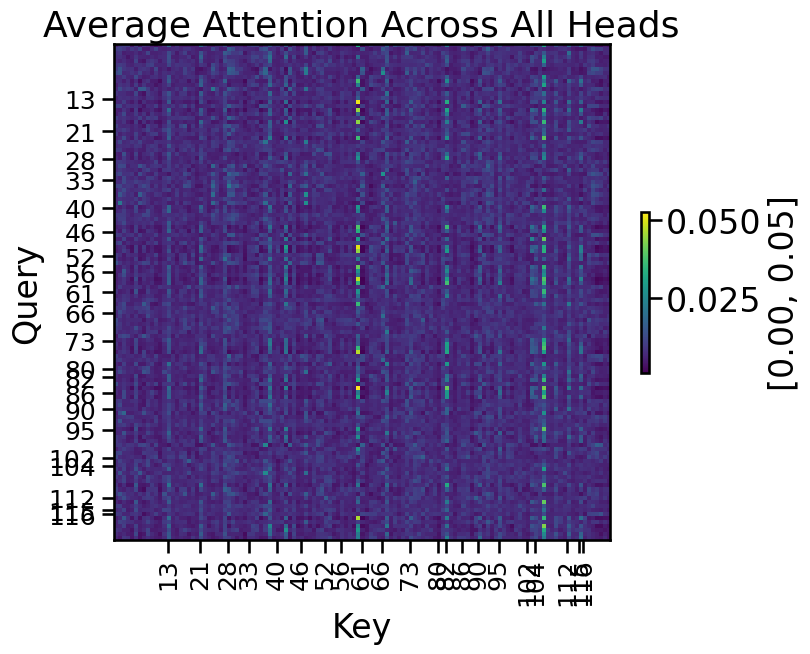

In [106]:
avg_base_smt_60dim_attn_ukbb = np.load('./notebooks/NeurIPS/attn_heads/attn_base_SMT_full_training.npy')
summed_attention_vec = plot_average_head(avg_base_smt_60dim_attn_ukbb, chrom_switches, vectorize=True)


In [113]:
import gseapy as gp

gene_attention_df = gene_attention_df.sort_values('Attention_Score', ascending=False)
# write without header
gene_attention_df[['Gene','Attention_Score']].to_csv(f'gene_attention_{token_chunk_size}_dim.rnk',
                                                   sep='\t', index=False,
                                                   header=False)

pre_res = gp.prerank(
    rnk='gene_attention.rnk',
    gene_sets='KEGG_2021_Human',
    min_size=15,              # Minimum gene set size
    max_size=7380,             # Maximum gene set size
    permutation_num=1000,     # Number of permutations
    weight=.1,                 # Weight for ranking
    ascending=False,          # Sort descending
    threads=4,                # Number of threads
    figsize=[6.5,6],         # Figure size
    outdir=None,             # Don't write files
    format='pdf',            # Figure format
    graph_num=20,            # Plot top 20 enriched sets
    no_plot=False,           # Generate plots
    seed=42,                 # Random seed
    verbose=True             # Print progress
)

2025-07-16 21:26:52,554 [WARNING] Duplicated values found in preranked stats: 95.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-16 21:26:52,554 [INFO] Parsing data files for GSEA.............................
2025-07-16 21:26:52,554 [INFO] Enrichr library gene sets already downloaded in: /home/asr655/.cache/gseapy, use local file
2025-07-16 21:26:52,564 [INFO] 0068 gene_sets have been filtered out when max_size=7380 and min_size=15
2025-07-16 21:26:52,565 [INFO] 0252 gene_sets used for further statistical testing.....
2025-07-16 21:26:52,565 [INFO] Start to run GSEA...Might take a while..................
2025-07-16 21:26:54,669 [INFO] Congratulations. GSEApy runs successfully................



In [114]:
pre_res.res2d.head(20)

Name                                     Term        ES       NES  \
0   prerank          Staphylococcus aureus infection  0.354208  2.165176   
1   prerank  Neuroactive ligand-receptor interaction  0.156526  2.017656   
2   prerank               JAK-STAT signaling pathway -0.242607 -1.963577   
3   prerank                   Fanconi anemia pathway  -0.38934 -1.949694   
4   prerank                 Type I diabetes mellitus  0.403164  1.902756   
5   prerank        Ribosome biogenesis in eukaryotes  0.354264  1.802876   
6   prerank      Antigen processing and presentation  0.284127  1.797688   
7   prerank               Hematopoietic cell lineage  0.299338  1.761578   
8   prerank          Arginine and proline metabolism  0.273074  1.727687   
9   prerank      Aldosterone synthesis and secretion   0.19351  1.721403   
10  prerank             Epstein-Barr virus infection -0.153536 -1.660382   
11  prerank               Nucleotide excision repair -0.343978 -1.657756   
12  prerank                   cAMP signaling pathway  0.132177  1.630906   
13  prerank       Cysteine and methionine metabolism  0.262541  1.628607   
14  prerank                          Renin secretion  0.234819  1.619658   
15  prerank                   Small cell lung cancer -0.213614 -1.595777   
16  prerank               cGMP-PKG signaling pathway  0.142498  1.550212   
17  prerank                        Viral myocarditis -0.263196  -1.52866   
18  prerank               Non-small cell lung cancer  0.210041  1.510301   
19  prerank             Systemic lupus erythematosus  0.256656  1.473658   

   NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
0        0.0  0.273535      0.205   19/27  35.72%   
1        0.0  0.329761      0.398  43/132  17.85%   
2   0.008791  0.730809      0.435   28/44  38.67%   
3   0.010917  0.390486      0.457   15/17  48.96%   
4   0.003839  0.418069      0.589   12/15  40.38%   
5    0.01711  0.550362      0.759   10/18  21.33%   
6   0.009042  0.453055      0.767   19/30  35.72%   
7   0.019268   0.46045      0.816   18/25  42.82%   
8   0.023636  0.470509      0.861   24/29  56.27%   
9   0.024482  0.422206      0.862   38/58  47.20%   
10  0.017778       1.0      0.905   67/81  67.15%   
11  0.037118   0.91056      0.908   14/16  52.76%   
12  0.046233  0.600876      0.959  66/117  44.36%   
13  0.040462  0.546259      0.959   23/28  56.64%   
14  0.043643  0.519532      0.963   26/35  51.64%   
15  0.049661  0.971199      0.956   32/39  60.41%   
16  0.047452  0.658425      0.991   54/89  47.43%   
17  0.072165       1.0      0.983   20/22  64.47%   
18   0.07193  0.731374      0.997   24/38  43.31%   
19  0.068223  0.798244      0.999   14/23  36.30%   

                                           Lead_genes  
0   C3;KRT31;KRT14;KRT19;KRT17;FCGR3A;C1S;C1R;ITGB...  
1   NTSR2;GRM7;OXTR;NPFFR2;NMU;HTR2A;LPAR6;GABRA3;...  
2   JAK2;STAM2;SOCS1;BCL2;PIAS2;IL15;CCND1;SOCS5;P...  
3   FANCL;ERCC4;RMI2;RPA2;PMS2;TOP3A;HES1;REV1;RAD...  
4   IL1B;ICA1;HLA-DMB;HLA-DMA;HLA-DPB1;HLA-DPA1;HL...  
5   RPP25;RAN;IMP4;POP7;HEATR1;NHP2;TCOF1;BMS1;EMG...  
6   CTSL;CANX;CD74;RFX5;KLRC3;KLRC2;PDIA3;B2M;CD8B...  
7   IL1B;CSF1R;CD24;CD8B;IL4R;CD33;ITGAM;IL3RA;CD5...  
8   OAT;SAT2;GOT2;ALDH1B1;ALDH9A1;P4HA1;GOT1;CKMT1...  
9   CAMK1;ITPR1;ATF4;CACNA1I;ATP2B3;GNAQ;LIPE;CACN...  
10  IRAK4;HDAC1;BCL2;TNF;HLA-C;RAC1;CCND1;PIK3CB;N...  
11  ERCC4;RPA2;RFC1;ERCC2;ERCC8;POLE4;ERCC6;RFC3;R...  
12  ROCK2;OXTR;PAK1;ATP2B3;VAV1;LIPE;RYR2;ADCYAP1R...  
13  BHMT2;PSAT1;AHCYL1;GOT2;DNMT3A;LDHB;BCAT1;GCLM...  
14  PPP3CC;ITPR1;GNAQ;AQP1;ADCYAP1R1;EDN1;PPP3R1;A...  
15  BCL2;CCND1;PIK3CB;RXRA;NFKB1;PIK3R1;IKBKB;TRAF...  
16  PPP3CC;ROCK2;ITPR1;ATF4;ATP2B3;INSR;GNAQ;ATP1B...  
17  HLA-C;RAC1;CCND1;ACTG1;BID;DMD;LAMA2;CXADR;FYN...  
18  PLCG2;MAPK1;HGF;MAP2K2;SOS2;PIK3CD;MET;RET;RAS...  
19  ACTN4;C3;SNRPB;FCGR3A;C1S;C1R;HLA-DMB;HLA-DMA;...

In [117]:
from gseapy.plot import dotplot

ax = dotplot(
    df=pre_res.res2d,
    title='GSEA: Enriched Pathways (Attention‑ranked genes)',
    column='FWER p-val',  # Default column name for FDR values
    x='NES',                   # x-axis = normalized enrichment score 
    y='Term',                  # y-axis = pathway names
    cutoff=0.1,              # Only show terms with adj p-value < 0.05
    top_term=15,              # Show top 15 enriched terms
    size=10,                  # Base dot size
    figsize=(6,8),
    cmap='RdYlBu_r',         # Red-Yellow-Blue colormap (reversed)
    xticklabels_rot=45,      # Rotate x-axis labels 45 degrees
    marker='o'               # Use circular markers
)
ax.figure.tight_layout()
# ax.figure.savefig('gsea_dotplot.pdf', dpi=300)

ValueError: Warning: No enrich terms when cutoff = 0.1